In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
print(Measurement)
Station = Base.classes.station
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

#create reference for tables:
inspector = inspect(engine)

for x in inspector.get_table_names():
    print(f"TABLE NAME {x}")
    for y in inspector.get_columns(x):
        print(y["name"], y["type"])
    

TABLE NAME measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
TABLE NAME station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
for x in session.query(Measurement.date).order_by(Measurement.date.desc()).first():
    last_date=x
oneyearago= dt.strptime(last_date, '%Y-%m-%d') - timedelta(days=365)
oneyearago=dt.strftime(oneyearago, '%Y-%m-%d')
oneyearago

'2016-08-23'

In [43]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and 
df=pd.DataFrame(session.query(Measurement.date, Measurement.prcp)\
                .filter(Measurement.date >= oneyearago)\
.all(), columns=['Date', 'Precepitation'])

df.set_index("Date", inplace=True)
df=df.sort_index()
df.head()

# set the index to the date column

,Precepitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


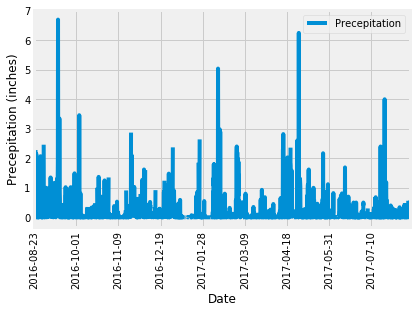

<Figure size 432x288 with 0 Axes>

In [28]:
# Use Pandas Plotting with Matplotlib to plot the 
graph1=df.plot(rot=90)
graph1.set_xlabel("Date", fontsize=12)
graph1.set_ylabel("Precepitation (inches)", fontsize=12)

plt.show()
plt.savefig("./Images/Precepitation.png")

In [49]:
help(df.sort_index)

Help on method sort_index in module pandas.core.frame:

sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort', na_position='last', sort_remaining=True, by=None) method of pandas.core.frame.DataFrame instance
    Sort object by labels (along an axis)
    
    Parameters
    ----------
    axis : index, columns to direct sorting
    level : int or level name or list of ints or list of level names
        if not None, sort on values in specified index level(s)
    ascending : boolean, default True
        Sort ascending vs. descending
    inplace : bool, default False
        if True, perform operation in-place
    kind : {'quicksort', 'mergesort', 'heapsort'}, default 'quicksort'
         Choice of sorting algorithm. See also ndarray.np.sort for more
         information.  `mergesort` is the only stable algorithm. For
         DataFrames, this option is only applied when sorting on a single
         column or label.
    na_position : {'first', 'last'}, default 'l

In [13]:


# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()









,Precepitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Measurement.station).group_by(Measurement.station).count()
print(station_count)

9


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
Station_List=pd.DataFrame(session.query(Measurement.station), columns=['Station count'])
Station_List=pd.DataFrame(pd.value_counts(Station_List['Station count']), columns=['Station count'])
Station_List["Station ID"]=Station_List.index
Station_List
# List the stations and the counts in descending order.


,Station count,Station ID
USC00519281,2772,USC00519281
USC00519397,2724,USC00519397
USC00513117,2709,USC00513117
USC00519523,2669,USC00519523
USC00516128,2612,USC00516128
USC00514830,2202,USC00514830
USC00511918,1979,USC00511918
USC00517948,1372,USC00517948
USC00518838,511,USC00518838


In [26]:
results=session.query(Measurement.station, Measurement.tobs)
average=pd.DataFrame(session.query(Measurement.station, Measurement.tobs).group_by(Measurement.station), columns=['Station ID', 'Average'])

lowlist=[]
highlist=[]
# Using the station id from the previous query, calculate the lowest temperature recorded, 
for x in average["Station ID"]:
    low=99
    high=0
    for y in results:
        if x==y[0]:
            if y[1]<low:
                low=y[1]
            if y[1]>high:
                high=y[1]
    lowlist.append(low)
    highlist.append(high)
average["High"]=highlist
average["Low"]=lowlist
pd.merge(Station_List, average, on='Station ID')

# highest temperature recorded, and average temperature most active station?


,Station count,Station ID,Average,High,Low
0,2772,USC00519281,70.0,85.0,54.0
1,2724,USC00519397,65.0,87.0,56.0
2,2709,USC00513117,67.0,85.0,59.0
3,2669,USC00519523,75.0,85.0,56.0
4,2612,USC00516128,73.0,84.0,58.0
5,2202,USC00514830,67.0,85.0,58.0
6,1979,USC00511918,66.0,87.0,53.0
7,1372,USC00517948,75.0,87.0,58.0
8,511,USC00518838,72.0,83.0,58.0


In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results=pd.DataFrame(session.query(Measurement.station, Measurement.tobs).filter(Measurement.station=="USC00519281", Measurement.date >= oneyearago ))
Frequency=pd.DataFrame(results["tobs"].value_counts())
xmin=results["tobs"].min()
xmax=results["tobs"].max()




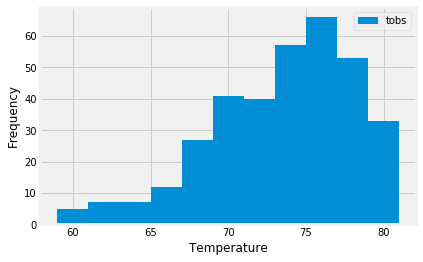

In [42]:
#make bar chart

results.plot(kind="hist", bins=np.arange(start=xmin, stop=xmax, step=(xmax-xmin)/12) )
# help with bins?
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show()



![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:


while x<=last_date:
    y=calc_temps(x, z)
    y=str(y[0])
    y=y.replace("(", "")
    y=y.replace(" ", "")
    y=y.replace(")","")
    arr = y.split(",")
    Min.append(arr[0])
    average.append(arr[1])
    Max.append(arr[2])
    date.append(x)
    x= dt.strftime(dt.strptime(x, '%Y-%m-%d') + timedelta(days=1), '%Y-%m-%d')
    z= dt.strftime(dt.strptime(z, '%Y-%m-%d') + timedelta(days=1), '%Y-%m-%d')
lib={
    'date':date,
    'min':Min, 
    'average':average,
    'max':Max
    
}
info=pd.DataFrame(lib)
info

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
